# Training CPPNs and visualizing them for different images and architectures

In this notebook, we will use different architectures and images to train the network on to see how well it performs. We can experiment with changing the shape and size of the network, or introducing bottlenecks to see how it impacts the training process.

In [12]:
# reload imports so if you change stuff in models/cppn.py it'll update the notebook periodically to see it.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/01_CPPN')
from models.cppn import CPPN, Sampler, multiscale_targets_apply

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm

from IPython.display import display, clear_output
import time

## Utility functions

In [14]:
def crop_to_square_and_resize(img, new_width_height):
    # Get the dimensions of the image
    width, height = img.size

    # Determine the size of the square
    new_size = min(width, height)

    # Calculate the left, top, right, and bottom coordinates for the crop
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    # Crop the image to a square
    img_cropped = img.crop((left, top, right, bottom))
    # Resize
    img_resized = img_cropped.resize(new_width_height)

    return img_resized

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

Let's load a bunch of images to train on!

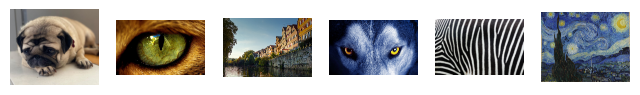

In [15]:
TRAINING_RES = 512
target_files = [
    '../targets/pug.png',
    '../targets/eye1.jpg',
    '../targets/tu2.jpg',
    '../targets/wolf.jpg',
    '../targets/zebra.jpg',
    '../targets/starry.jpg',
]

labels = [
    'Ginger the Pug',
    'Feline Eye',
    'Tübingen',
    'Wolf Eyes',
    'Zebra Pattern',
    'Starry Night'
]

imgs = [Image.open(file) for file in target_files]

fig, axes = plt.subplots(1, len(target_files), figsize=(8., 5))

for i, ax in enumerate(axes):
    ax.imshow(np.array(imgs[i]))
    ax.axis('off')
    
MSELoss = nn.MSELoss()

In [16]:
def train(cppn, num_epochs, img):
    
    # set up the shape of the tensors
    shape = np.array(img).shape
    aspectratio = shape[0] / shape[1]
    XRES=TRAINING_RES
    YRES=int(XRES * aspectratio)
    BATCH_SIZE=1
    
    # set up the target image
    
    # to be used later (probably haphazardly) to help normalize values
    img_mean = np.mean(img)
    img_std = np.std(img)
    
    TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
    TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
    TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))
    
    var_z = 0.00 # variation in latent vector z across batch  
    scale_in = scale    
    z_in = zscale * z.repeat(BATCH_SIZE, 1)
    
    # set up the optimizer and scheduler
    optim = torch.optim.Adam(cppn.parameters(), lr=1e-3)
    lambda1 = lambda epoch: 1 / (1 + epoch // 150)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda1)
    
    need_new_grid = True 
    losses = []
    for epoch in range(num_epochs):
        optim.zero_grad()
        
        # make a new delta_z with some random variation from var_z
        delta_z = var_z*torch.randn(BATCH_SIZE, dim_z).cuda()
        zt = z_in + delta_z
    
        if need_new_grid:
            x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)                
            need_new_grid = False
        else:
            x = x[:-1]
            x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z
    
    
    
        out = cppn.forward(x)
        
        # normalizing by taking the batch and spatial and RGB channel means and stds
        # this step has a lot of consequences for proper training 
        # and it's not clear this implementation is very good
    
        out = (out - out.mean(dim=[0, 1, 2], keepdim=True)) / out.std(dim=[0, 1, 2], keepdim=True)
        # out = (out - img_mean) / img_std  # this was another implementation that also worked
        
        # doing the same for the target
        target = (TARGET - img_mean) / img_std
        # loss = MSELoss(out, target) # color loss
        loss = MSELoss(out.mean(2), target.mean(2)) # b/w loss (often prettier because the colours get to do what the want)
        loss.backward()
        optim.step()
        scheduler.step()
        
        losses.append(loss.item())
         
        
        if epoch % 30 == 0:
            
            rand_ind = np.random.randint(len(out)) # used to plot a random batch example 
            # rand_ind = 0
            # nx = min_max(out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1) * img_std + img_mean)
            nx = min_max(out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1))
            # nx = out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1)
            alpha = 0.5
            s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:]) 
    
            plt.clf()
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))
            ax[0].imshow(nx)
            ax[2].plot(s_losses)  # smoothed losses
            ax[2].scatter(np.arange(len(losses)), losses, s=2)  # unsmoothed losses
            # ax[1].imshow(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3) / 255.)
            ax[1].imshow(min_max(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3)))
    
            clear_output(wait=True)
            display(plt.gcf())
            print(f'{epoch}')
            time.sleep(0.001)
            plt.close()
        
        # slowly grow the target image size over training (not sure this is nice)
        if epoch % 4000 == 0 and epoch != 0:
            XRES += 4
            YRES += 4 
            need_new_grid = True
            
            TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))            
            TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')    
            TARGET = torch.cuda.FloatTensor(TARGET)

Let's set up a list of architectures we want to explore that might be interesting.

In [17]:
net_sizes = [
    3 * [512] + [9, 3],
    3 * ([512, 256, 32]), # [256, 256, 128, 64, 64, 8], # this one is so pretty :(
    [1024, 512, 256, 128] + [2],
    [256, 256, 128, 64, 64, 8],
    [8, 256, 256, 64, 32, 6, 6, 6]
]
dim_z = 16
dim_c = 3

# Fourier Features settings
proj_dims = [128]
proj_scales = [2. for i in proj_dims]
projection_config = (proj_dims, proj_scales)


# Generate an Example Image

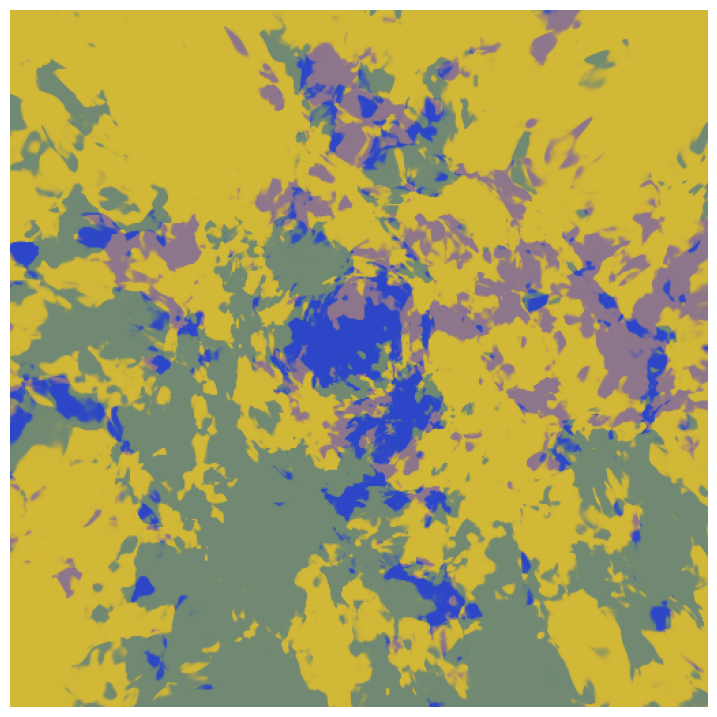

In [18]:
idx_net = 2
cppn = CPPN(net_sizes[idx_net], dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)
cppn.reinit(empty_cache=True)

gscale = 1
scale = 1.
xres = 512
yres = 512
zscale = 1.
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

# coords[2] = coords[2] * 0.

x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow((x * 255).astype(np.uint8))

Now let's make some images with each of the different architectures for a number of different instances.

# Generate images

Make a loop that generates images with a number of different architectures with a couple of instances of each architecture.

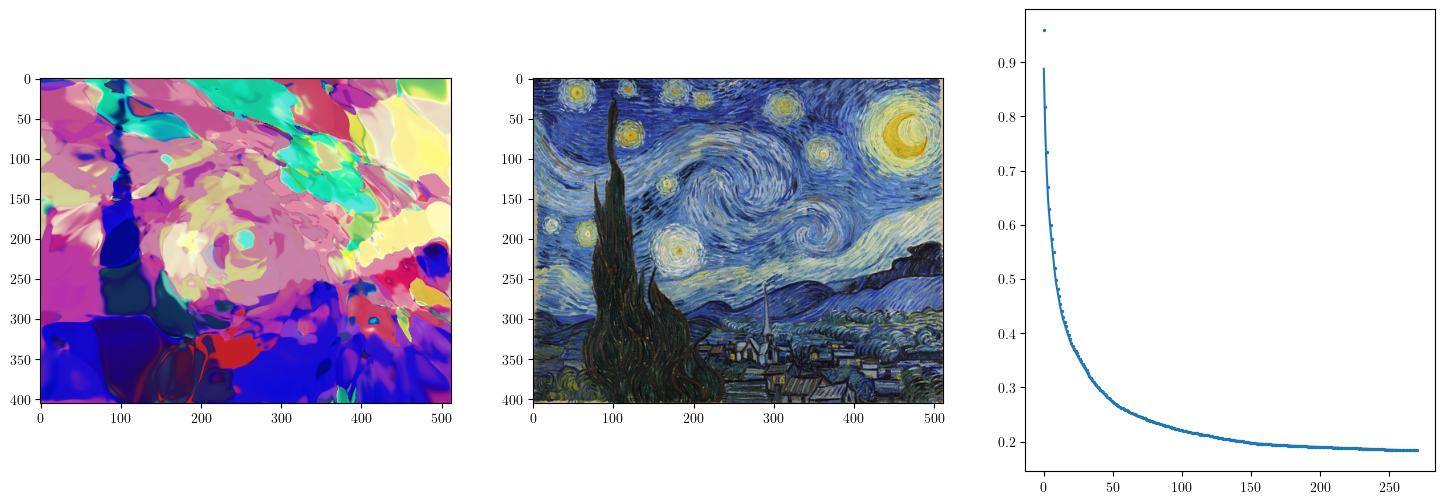

270


<Figure size 640x480 with 0 Axes>

In [19]:
training_epochs = 300

figure_imgs = []
for i_arch in range(len(net_sizes)):
    cppn = CPPN(net_sizes[i_arch], dim_z, dim_c, projection_config=projection_config).cuda()
    
    arch_images = []
    
    # train on the different target images
    for i_m, img in enumerate(imgs):
        # reinit the model
        cppn.reinit(empty_cache=True)
        
        # train the model on the target image
        train(cppn, training_epochs, img)
        
        # (re-)calculate the output shape
        shape = np.array(img).shape
        aspectratio = shape[0] / shape[1]
        
        XRES=TRAINING_RES
        YRES=int(XRES * aspectratio)
        
        with torch.no_grad():
            coords = cppn._coordinates(scale*gscale,
                           XRES, YRES, z*zscale*gscale)
            x = sampler.generate_img(cppn, z*zscale, scale, XRES, YRES, coords=coords)
        
        arch_images.append(x)
    figure_imgs.append(arch_images)

# Settings up the figures

In [20]:
plt.rcdefaults()
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': 10})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 10
})


cm = 1/2.54  # centimeters in inches

# size of full-width figures:
#fig = plt.figure(figsize=(18*cm, xx*cm))

# size of half-width figures:
#fig = plt.figure(figsize=(9*cm, 12.4*cm))

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_6952\1667468701.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


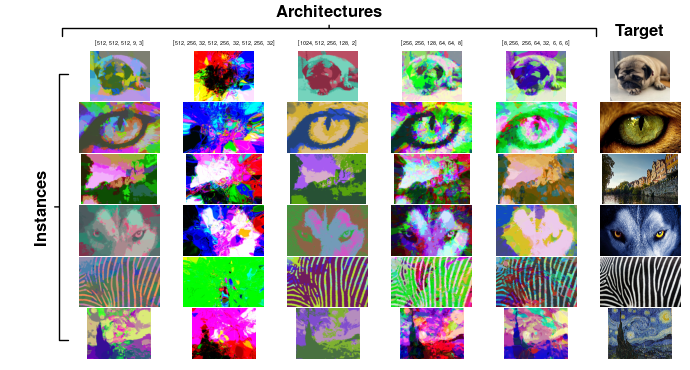

In [21]:
N = len(net_sizes) + 1
M = len(imgs)

fig, axes = plt.subplots(nrows=M, ncols=N, figsize=(8, 4))

# Loop through the grid and display images
for i in range(M): #rows
    for j in range(0, N): #columns
        ax = axes[i, j]
        
        # plot the target images 
        if j == (N - 1):
            ax.imshow(imgs[i])
            ax.set_xlabel(labels[i], fontsize=8)

        # plot the cppn images
        if j < (N - 1):
            ax.imshow(figure_imgs[j][i])
            if i == 0:
                fig.text(0.5, 1.15, ''.join(str(net_sizes[j])), 
                         transform=ax.transAxes, ha='center', va='center',
                         fontsize=4)
            
        ax.axis('off')
# Manually position a text annotation
fig.text(0.5, 1.4, r'\textbf{Target}', transform=axes[0, -1].transAxes, ha='center', va='center', fontsize=12)
model_mid_x = 0.06 + (N-1)/N/2 # (hspace + number of relevent columns)/2
plt.annotate(r'\textbf{Architectures}', xy=(model_mid_x, 0.915), xytext=(model_mid_x, 0.945), xycoords='subfigure fraction',
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=16, lengthB=.5', lw=1.0, color='k'))

model_mid_y = -0.06 + 0.5
plt.annotate(r'\textbf{Instances}', xy=(0.09, model_mid_y), xytext=(0.06, model_mid_y),
            xycoords='subfigure fraction', rotation=90,
            fontsize=12, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=.5', lw=1.0, color='k'))

plt.tight_layout()

plt.subplots_adjust(wspace=0.05, hspace=0.02) 
# plt.savefig('../figures/cppn_training_new.pdf', bbox_inches='tight', dpi=900)

plt.show()

Let's try a version that's rotated.

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_6952\2603607329.py:44: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


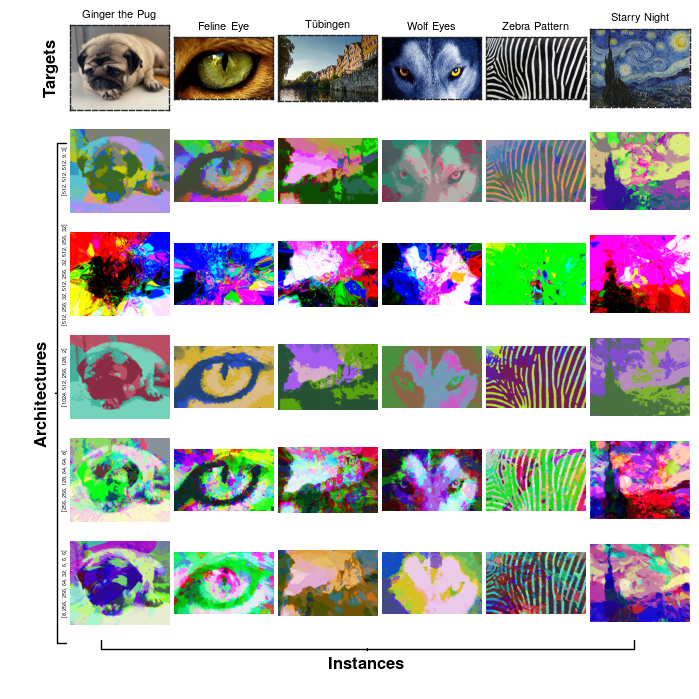

In [23]:
N = len(imgs)
M = len(net_sizes) + 1

fig, axes = plt.subplots(nrows=M, ncols=N, figsize=(8, 8))

# Loop through the grid and display images
for i in range(M): #rows
    for j in range(0, N): #columns
        ax = axes[i, j]
        
        # plot the target images 
        if i == 0:
            ax.imshow(imgs[j])
            ax.set_title(labels[j], fontsize=8)
            
            ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
            for spine in ax.spines.values():
                spine.set_edgecolor('#262626')
                spine.set_linewidth(1)
                spine.set_linestyle('--')

        # plot the cppn images
        if i > 0:
            ax.imshow(figure_imgs[i-1][j])
            if j == 0:
                fig.text(-0.05, 0.5, ''.join(str(net_sizes[i-1])), 
                         transform=ax.transAxes, ha='center', va='center',
                         fontsize=4, rotation=90)
            
            ax.axis('off')
# # Manually position a text annotation
fig.text(-0.2, 0.5, r'\textbf{Targets}', transform=axes[0, 0].transAxes, ha='center', va='center', fontsize=12, rotation=90)
model_mid_x = 0.025 + 0.5 # (hspace + number of relevent columns)/2
plt.annotate(r'\textbf{Instances}', xy=(model_mid_x, 0.072), xytext=(model_mid_x, 0.05), xycoords='subfigure fraction',
            fontsize=12, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=16, lengthB=.5', lw=1.0, color='k'))

model_mid_y = (M-1)/M/2 + 0.02
plt.annotate(r'\textbf{Architectures}', xy=(0.082, model_mid_y), xytext=(0.06, model_mid_y),
            xycoords='subfigure fraction', rotation=90,
            fontsize=12, ha='center', va='center',
            arrowprops=dict(arrowstyle='-[, widthB=15, lengthB=.5', lw=1.0, color='k'))

plt.tight_layout()

plt.subplots_adjust(wspace=0.05, hspace=0.02) 
plt.savefig('../figures/cppn_training_new_rotated.pdf', bbox_inches='tight', dpi=900)

plt.show()